In [ ]:
import torch
import urllib
import PIL.Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from unet import UNet
import torch
import torch.nn as nn

class DownSampleBlock(nn.Module):
    def __init__(self,in_channels,out_channels,t_emb_dim,down_sample,num_heads):
        super().__init__()
        self.down_sample=down_sample
        self.resnet_conv_first=nn.Sequential(
            nn.GroupNorm(8,in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
        )
        self.t_emb_layer=nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim,out_channels)
        )
        self.resnet_conv_second=nn.Sequential(
            nn.GroupNorm(8,out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        )
        self.attention_norm=nn.GroupNorm(8,out_channels)
        self.attn=nn.MultiheadAttention(out_channels,num_heads,batch_first=True)
        self.residual_input_conv=nn.Conv2d(in_channels,out_channels,kernel_size=1)
        self.down_sample_conv=nn.Conv2d(out_channels,out_channels,kernel_size=4,stride=2,padding=1) if self.down_sample else nn.Identity()

    def forward(self,x,t_emb):
        out=x
        resnet_input =out
        out = self.resnet_conv_first(out)
        out = out+ self.t_emb_layer(t_emb)[:,:,None,None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)
        
        batch_size,channels,h,w=out.shape
        in_attn = out.reshape(batch_size,channels,h*w).transpose(1,2)
        out_attn, _ = self.attn(in_attn,in_attn,in_attn)
        out_attn = out_attn.transpose(1,2).reshape(batch_size,channels,h,w)
        out = out+out_attn

        out = self.down_sample_conv(out)

        return out
    

class MidBlock(nn.Module):
    def __init__(self,in_channels,out_channels,t_emb_dim,n_heads):
        super().__init__()
        self.first_resnet_conv= nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8,in_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
            ),
            nn.Sequential(
                nn.GroupNorm(8,out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
            )
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim,out_channels)
            ),
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim,out_channels)
            )
        ])

        self.second_resnet_conv= nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8,out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
            ),
            nn.Sequential(
                nn.GroupNorm(8,out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
            )
        ])

        self.attn_norm = nn.GroupNorm(8,out_channels)
        self.attn=nn.MultiheadAttention(out_channels,n_heads,batch_first=True)
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels,out_channels,kernel_size=1),
            nn.Conv2d(out_channels,out_channels,kernel_size=1)
        ]
        )


    def forward(self,x,t_emb):
        out=x
        resnet_input =out
        out = self.first_resnet_conv[0](out)
        out = out+ self.t_emb_layers[0](t_emb)[:,:,None,None]
        out = self.second_resnet_conv[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        batch_size,channels,h,w=out.shape
        in_attn = out.reshape(batch_size,channels,h*w).transpose(1,2)
        out_attn, _ = self.attn(in_attn,in_attn,in_attn)
        out_attn = out_attn.transpose(1,2).reshape(batch_size,channels,h,w)
        out = out+out_attn

        resnet_input =out
        out = self.first_resnet_conv[1](out)
        out = out+ self.t_emb_layers[1](t_emb)[:,:,None,None]
        out = self.second_resnet_conv[1](out)
        out = out + self.residual_input_conv[1](resnet_input)
               

        return out
    


class UpSampleBlock(nn.Module):
    def __init__(self,in_channels,out_channels,t_emb_dim,up_sample,num_heads):
        super().__init__()
        self.up_sample=up_sample
        self.resnet_conv_first=nn.Sequential(
            nn.GroupNorm(8,in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
        )
        self.t_emb_layer=nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim,out_channels)
        )
        self.resnet_conv_second=nn.Sequential(
            nn.GroupNorm(8,out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        )
        self.attention_norm=nn.GroupNorm(8,out_channels)
        self.attn=nn.MultiheadAttention(out_channels,num_heads,batch_first=True)
        self.residual_input_conv=nn.Conv2d(in_channels,out_channels,kernel_size=1)
        self.up_sample_conv=nn.ConvTranspose2d(in_channels//2,in_channels//2,kernel_size=4,stride=2,padding=1) if self.up_sample else nn.Identity()

    def forward(self,x,out_dowm,t_emb):

        x=self.up_sample_conv(x)#upsamples to half the channels
        x= torch.cat([x,out_dowm],dim=1)

        #resnet
        out=x
        resnet_input =out
        out = self.resnet_conv_first(out)
        out = out+ self.t_emb_layer(t_emb)[:,:,None,None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)
        #self attn
        batch_size,channels,h,w=out.shape
        in_attn = out.reshape(batch_size,channels,h*w).transpose(1,2)
        #print("in_attn shape:",in_attn.shape)
        out_attn, _ = self.attn(in_attn,in_attn,in_attn)
        out_attn = out_attn.transpose(1,2).reshape(batch_size,channels,h,w)
        out = out+out_attn

        return out
    
class UNet(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.down_channels=[32,64,128,256]
        self.mid_channels=[256,256,128]
        self.t_emb_dim=128
        self.down_sample=[True,True,False]
        self.up_sample=list(reversed(self.down_sample))

        #to get initial timestep processed, call it before any forward op in unet
        self.t_proj=nn.Sequential(
            nn.Linear(self.t_emb_dim,self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim,self.t_emb_dim)
        )

        #to convert initial images to required no of channels
        self.conv_input=nn.Conv2d(in_channels,self.down_channels[0],kernel_size=3,padding=1)

        self.downs=nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownSampleBlock(self.down_channels[i],self.down_channels[i+1],self.t_emb_dim,self.down_sample[i],num_heads=4))


        self.mids=nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i],self.mid_channels[i+1],self.t_emb_dim,n_heads=4))
        
        self.ups=nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpSampleBlock(self.down_channels[i]*2,self.down_channels[i-1] if i!=0 else 16,self.t_emb_dim,self.down_sample[i],num_heads=4))

        self.norm_out=nn.GroupNorm(8,16)
        self.conv_out=nn.Conv2d(16,in_channels,kernel_size=3,padding=1)

    def get_time_embedding(self, time_steps, t_emb_dim):
        # time_steps: (B,)
        half_dim = t_emb_dim // 2

        device = time_steps.device
        time_steps = time_steps.float()

        factor = torch.exp(
            -torch.log(torch.tensor(10000.0, device=device)) *
            torch.arange(half_dim, device=device) / half_dim
        )  # (D/2,)

        # (B, 1) * (1, D/2) → (B, D/2)
        t = time_steps[:, None] * factor[None, :]

        t_emb = torch.cat([torch.sin(t), torch.cos(t)], dim=-1)  # (B, D)

        return t_emb



    def forward(self,x,t):
        #print(x.shape)
        out=self.conv_input(x)
        #print("Input to UNet:", out.shape)
        t_emb=self.get_time_embedding(t,self.t_emb_dim)
        #print(t_emb.shape)

        t_emb=self.t_proj(t_emb)

        down_outs=[]
        for down in self.downs:
            #print(out.shape)
            down_outs.append(out)
            out=down(out,t_emb)


        for mid in self.mids:
            #print(out.shape)
            out=mid(out,t_emb)

        for up in self.ups:
            down_out=down_outs.pop()
            #print(out.shape,down_out.shape)
            out=up(out,down_out,t_emb)
        
        out=self.norm_out(out)
        out=nn.SiLU()(out)
        out=self.conv_out(out)
        #print("Output of UNet:",out.shape)
        return out
    
            

            

In [7]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

In [8]:
transform =  transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t*2)-1)
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t+1)/2),
    transforms.Lambda(lambda t: t.permute(1,2,0)),
    transforms.Lambda(lambda t: t*255.),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])

In [31]:
class DiffusionModel:
    def __init__(self,start_schedule=0.0001,end_schedule=0.02,timesteps=100):
        device = "cuda:0"
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(self.start_schedule,self.end_schedule,self.timesteps).to(device)
        self.alphas = 1 -  self.betas
        self.alpha_t = torch.cumprod(self.alphas,dim=0).to(device)

    def forward(self,x0,t,device):
        #x0 is a batch of images
        # t is a batch of times
        noise = torch.rand_like(x0).to(device)
        result = self.alpha_t.gather(-1,t.to(device)).reshape(-1,1,1,1)
        mean = result.sqrt()*x0.to(device)
        variance = torch.sqrt(1-result)*noise
        mean=mean.to(device)
        variance=variance.to(device)
        return mean+variance,noise.to(device)
    
    @torch.no_grad()
    def backward(self, x_t, t, noise_pred):


        beta_t = self.betas.gather(0, t).reshape(-1, 1, 1, 1)
        alpha_t = self.alphas.gather(0, t).reshape(-1, 1, 1, 1)
        alpha_bar_t = self.alpha_t.gather(0, t).reshape(-1, 1, 1, 1)

        alpha_bar_t_prev = torch.where(
            t.reshape(-1,1,1,1) > 0,
            self.alpha_t.gather(0, t-1).reshape(-1,1,1,1),
            torch.ones_like(alpha_bar_t)
        )


        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
        x0_pred = torch.clamp(x0_pred, -1.0, 1.0)

        mean = (
            torch.sqrt(alpha_bar_t_prev) * beta_t / (1 - alpha_bar_t) * x0_pred
            +
            torch.sqrt(alpha_t) * (1 - alpha_bar_t_prev) / (1 - alpha_bar_t) * x_t
        )

        variance = beta_t * (1 - alpha_bar_t_prev) / (1 - alpha_bar_t)
        std = torch.sqrt(variance)

        noise = torch.randn_like(x_t)
        nonzero_mask = (t != 0).reshape(-1,1,1,1)

        x_prev = mean + nonzero_mask * std * noise
        return x_prev,x0_pred



<Figure size 1500x1500 with 0 Axes>

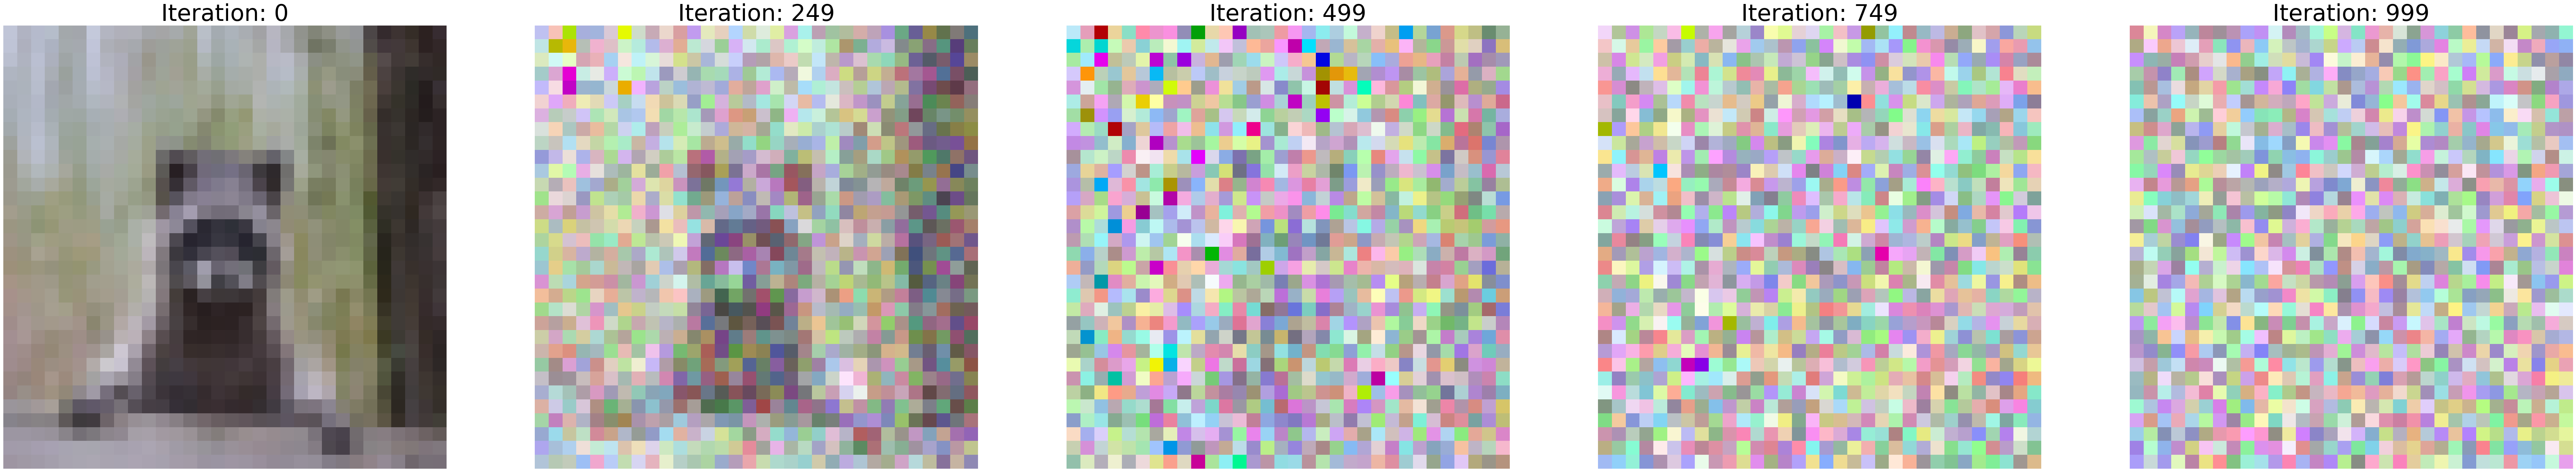

In [32]:
pil_image = get_sample_image()
torch_img = transform(pil_image)
model = DiffusionModel(timesteps=1000)

n_img = 5
imgs = torch.stack([torch_img]*n_img)
t = torch.linspace(0,model.timesteps-1,n_img).long()
noisy_imgs,_ =  model.forward(imgs,t,device)

plt.figure(figsize=(15,15))
f,ax = plt.subplots(1,n_img,figsize=(100,100))
for idx,img in enumerate(noisy_imgs):
    ax[idx].imshow(reverse_transform(img.cpu()))
    ax[idx].axis(False)
    ax[idx].set_title("Iteration: {}".format(t[idx].item()),fontsize = 50)

plt.show()

In [33]:

def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [34]:
unet = UNet(in_channels=3)
unet.to(device)
epochs = 100
PRINT_FREQUENCY = 5
lr = 0.001
batch_size =128
optimizer = torch.optim.Adam(unet.parameters(),lr=lr)
VERBOSE = True


mse_epoch = []
for epoch in range(epochs):
    imgs = torch.stack([torch_img]*batch_size)
    t = torch.randint(0,model.timesteps-1,(batch_size,)).long()
    noise_image,noise = model.forward(imgs,t,device)
    predicted_noise = unet(noise_image,t.to(device))

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise,predicted_noise)
    mse_epoch.append(loss)
    loss.backward()
    optimizer.step()
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {loss.item()}")
        if VERBOSE:
            with torch.no_grad():
                #plot_noise_prediction(noise[0], predicted_noise[0])
                #plot_noise_distribution(noise, predicted_noise)
                pass

---
Epoch: 0 | Train Loss 0.3737484812736511
---
Epoch: 5 | Train Loss 0.10410907119512558
---
Epoch: 10 | Train Loss 0.09076885879039764
---
Epoch: 15 | Train Loss 0.07855512946844101
---
Epoch: 20 | Train Loss 0.08043545484542847
---
Epoch: 25 | Train Loss 0.06347904354333878
---
Epoch: 30 | Train Loss 0.05338842794299126
---
Epoch: 35 | Train Loss 0.04515421390533447
---
Epoch: 40 | Train Loss 0.043216265738010406
---
Epoch: 45 | Train Loss 0.03748401254415512
---
Epoch: 50 | Train Loss 0.03374283015727997
---
Epoch: 55 | Train Loss 0.028720904141664505
---
Epoch: 60 | Train Loss 0.028558749705553055
---
Epoch: 65 | Train Loss 0.027847059071063995
---
Epoch: 70 | Train Loss 0.023841481655836105
---
Epoch: 75 | Train Loss 0.023289231583476067
---
Epoch: 80 | Train Loss 0.02169012278318405
---
Epoch: 85 | Train Loss 0.021001644432544708
---
Epoch: 90 | Train Loss 0.019195204600691795
---
Epoch: 95 | Train Loss 0.01872897520661354


In [57]:
pil_image = get_sample_image()
torch_img = transform(pil_image)
model = DiffusionModel(timesteps=1000)
device="cuda:0"
n_img = 5
imgs = torch.stack([torch_img]*n_img)
t = torch.linspace(1,model.timesteps-1,n_img).long()
noisy_imgs,_ =  model.forward(imgs,t,device)

pred,x0 = model.backward(noisy_imgs.to(device),t.to(device),unet(noisy_imgs.to(device),t.to(device)))

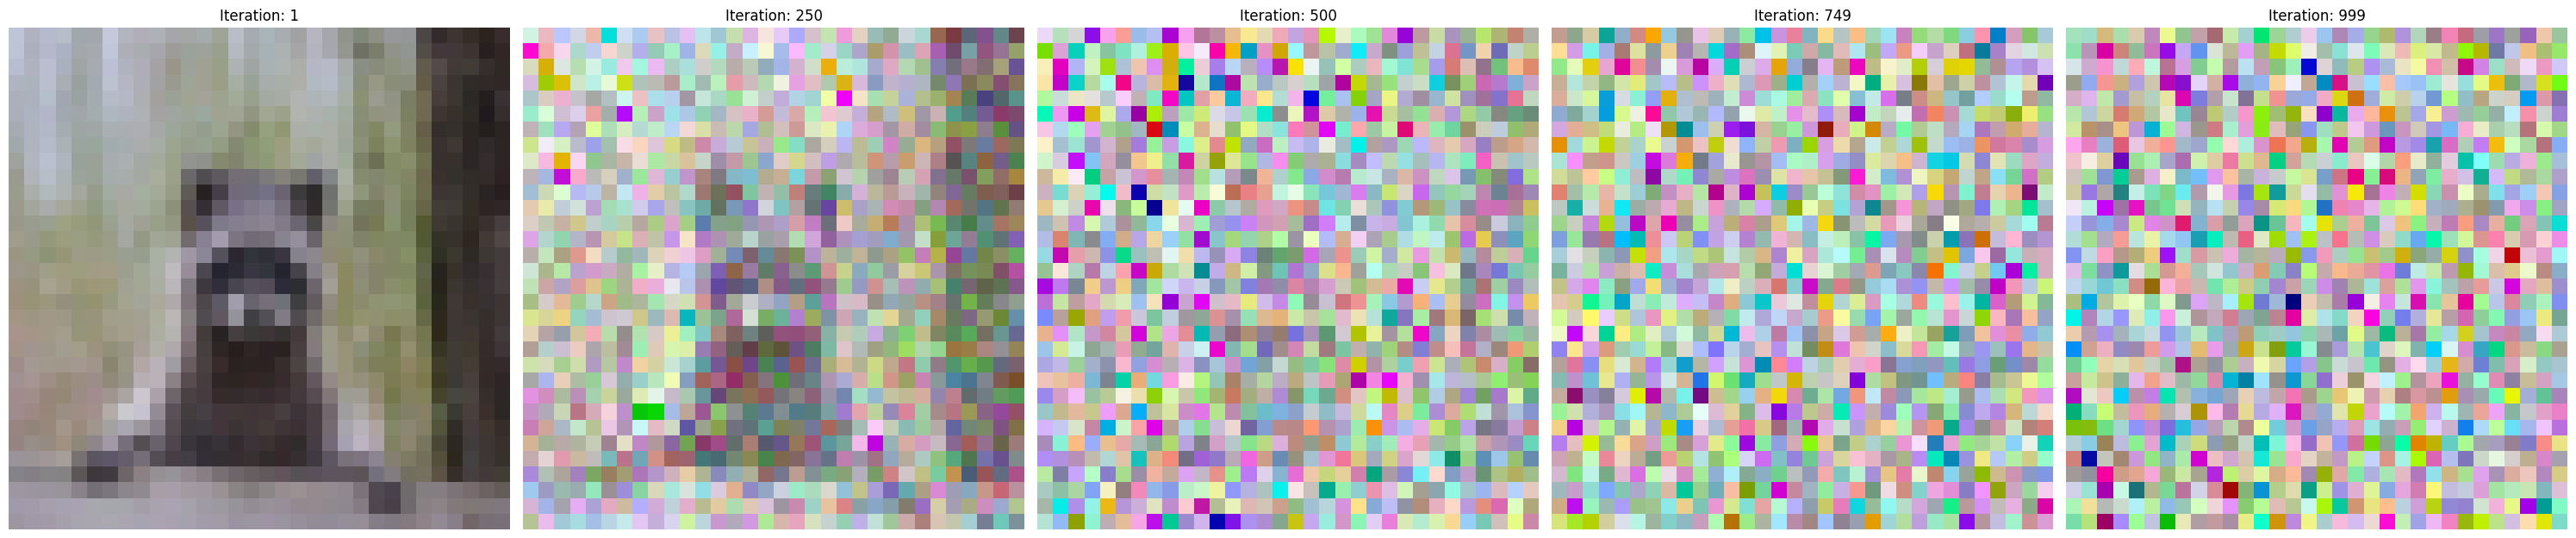

In [59]:
rows = 1
cols = 5

fig, ax = plt.subplots(rows, cols, figsize=(30,30))

for idx, img in enumerate(pred):
    r = idx // cols
    c = idx % cols

    ax[c].imshow(reverse_transform(img.cpu()))
    ax[c].axis("off")
    ax[c].set_title(
        f"Iteration: {t[idx].item()}",
        fontsize=12
    )

plt.tight_layout()
plt.show()
